In [1]:
import or_suite
import numpy as np

import copy

import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd


import gym

# OR Suite 

##  Ambulance Routing Environment

One potential application of reinforcement learning involves positioning a server or servers (in this case an ambulance) in an optimal way geographically to respond to incoming calls while minimizing the distance traveled by the servers. 

This is closely related to the [k-server problem](https://en.wikipedia.org/wiki/K-server_problem), where there are $k$ servers stationed in a space that must respond to requests arriving in that space in such a way as to minimize the total distance traveled. 

The ambulance routing problem addresses the problem by modeling an environment where there are ambulances stationed at locations, and calls come in that one of the ambulances must be sent to respond to. The goal of the agent is to minimize both the distance traveled by the ambulances between calls and the distance traveled to respond to a call by optimally choosing the locations to station the ambulances.


### Environment Visualization

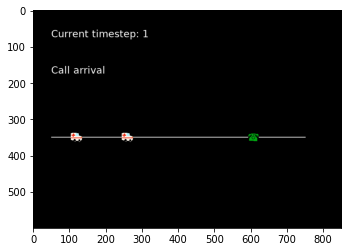

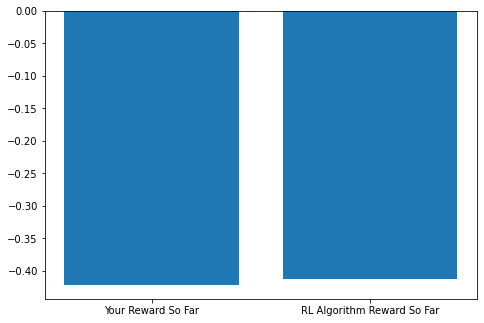


The most recent call arrival was at 0.79628444, and ambulance 2 responded to the call.



In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(500, 800))
display.start()

import or_suite
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import time
import copy

a = 5
b = 2
CONFIG = {'epLen': 5,
    'arrival_dist': lambda x : np.random.beta(a,b), 
    'alpha': 0.25, 
    'starting_state': np.array([0.0, 0.0]), 
    'num_ambulance': 2,
    'norm': 1
}

alpha = CONFIG['alpha']
epLen = CONFIG['epLen']
state = CONFIG['starting_state']
num_ambulance = CONFIG['num_ambulance']

agent = or_suite.agents.ambulance.command_line_metric.commandLineAgent(epLen)
env = gym.make('Ambulance-v0', config=CONFIG)
env.reset()


done = False
your_rewards = []
heuristic_agent_rewards = []
your_total_reward = 0
heuristic_agent_total_reward = 0

median_est = (a - 1/3)/(a + b - 2/3)
heuristic_agent_states = [state]

x_axis = ['Your Reward So Far', 'RL Algorithm Reward So Far']


def display_animation(screen, time_to_display):
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    if time_to_display is not None:
        ipythondisplay.display(plt.gcf())
        time.sleep(time_to_display)

def plot_rewards():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    y_axis = [your_total_reward, heuristic_agent_total_reward]
    ax.bar(x_axis, y_axis)
    plt.show()


while not done:
    action = agent.greedy(state, 0)
    state, reward, done, info = env.step(action)
    your_rewards.append(reward)
    your_total_reward += reward

    # by comparing the final state with the action the user chose, we can figure out where the most recent arrival was
    previous_arrival_ind = np.argmax(np.abs(action - state))
    previous_arrival = state[previous_arrival_ind]

    # the heuristic agent always chooses to put all the ambulances at the median estimate
    heuristic_agent_action = np.full(num_ambulance, median_est)

    # the state will have one ambulance where the call arrived, and all other ambulances at the median estimate
    # doesn't matter which ambulance responds to the call because they're all at the same place
    heuristic_agent_state = np.concatenate([np.full(num_ambulance - 1, median_est), [previous_arrival]])
    heuristic_agent_states.append(heuristic_agent_state)

    heuristic_agent_reward = -1 * (alpha * np.sum(np.abs(heuristic_agent_states[-2] - heuristic_agent_action)) + (1 - alpha) * np.sum(np.abs(heuristic_agent_action - heuristic_agent_state)))
    heuristic_agent_rewards.append(heuristic_agent_reward)
    heuristic_agent_total_reward += heuristic_agent_reward

    screen1, screen2, screen3 = env.render(mode='rgb_array')

    # display each step of the environment for 2 seconds
    display_animation(screen1, 2)
    display_animation(screen2, 2)
    display_animation(screen3, None)

    # plot your reward vs the agent's reward
    plot_rewards()
    time.sleep(2)

    print("\nThe most recent call arrival was at " + str(previous_arrival) + ", and ambulance " + str(previous_arrival_ind+1) + " responded to the call.\n")

    time.sleep(2)


ipythondisplay.clear_output(wait=True)
env.close()

if np.sum(your_rewards) >= np.sum(heuristic_agent_rewards):
    print("CONGRATS! You beat the RL algorithm.")
else:
    print("You did not get a better reward than the RL algorithm.")

print("\nYour total reward over all iterations was ", round(sum(your_rewards),3))
print("The RL algorithm's total reward over all iterations was ", round(sum(heuristic_agent_rewards),3), "\n")

plot_rewards()

This problem is well-studied in the setting where the number of ambulances $k$ is small and in simple metric spaces.  However,

- When the number of ambulances $k$ increases the complexity of the optimal policy increases dramatically
- In real-world situations, the problem gets complicated in more 'realistic' metrics (and a dataset based in Ithaca is provided)
- People construct a weighted metric for algorithm design, one cares about evaluating and balancing between multiple metrics
- How to evaluate if your RL algorithm is good? Need to benchmark against well-known heuristics for this problem to understand the value that RL approach brings